# Method 2 - Best Ideas High Size

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Size

size = inst_data.groupby(['datadate', 'institution_id'])['pos_val'].sum().rename('size').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Get Benchmark Weights

bm = crsp.get_crsp_market_portfolio()

# Merge Benchmark Weights onto Holdings

valid_data = valid_data.merge(bm, how='left', on=['datadate', 'fsym_id'])

# Grab Idiosyncratic Volatility

capm_var = crsp.get_capm_variance()

# Merge Idiosyncratic Volatility

valid_data = valid_data.merge(capm_var, how='left')

# Calculate Variance-Adjusted Market Tilt

valid_data['adj_target'] = (valid_data['target'] - valid_data['weight'].fillna(0)) * valid_data['capm_var']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Size

best_ideas = best_ideas.merge(size)
best_ideas['size_pct'] = best_ideas.groupby('datadate')['size'].rank(pct=True)
best_ideas = best_ideas[best_ideas['size_pct'] > (2 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

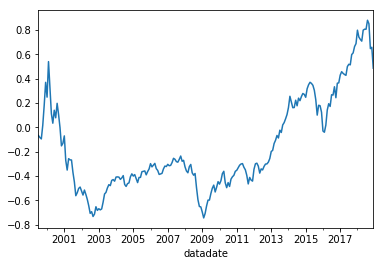

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.368850
2000-12-31   -0.366015
2001-12-31   -0.412948
2002-12-31   -0.376025
2003-12-31    0.753807
2004-12-31    0.108543
2005-12-31    0.064795
2006-12-31    0.030453
2007-12-31    0.075030
2008-12-31   -0.524473
2009-12-31    0.597410
2010-12-31    0.153351
2011-12-31   -0.126128
2012-12-31    0.332422
2013-12-31    0.485971
2014-12-31    0.149196
2015-12-31   -0.114946
2016-12-31    0.214236
2017-12-31    0.235828
2018-12-31   -0.119555
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     381.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          6.02e-100
Time:                        00:25:51   Log-Likelihood:                 507.41
No. Observations:                 234   AIC:                            -1005.
Df Residuals:                     229   BIC:                            -987.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.448      0.655      -0.003       0.005
mktrf          1.1694      0.052     22.417      0.000       1.067       1.272
me             0.4702      0.061      7.748      0.000       0.351       0.590
ia            -0.3213      0.092     -3.483      0.001      -0.503      -0.140
roe           -0.5666      0.079     -7.177      0.000      -0.722      -0.411
==============================================================================
Omnibus:                       17.782   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.876
Skew:                           0.290   Prob(JB):                     4.89e-10
Kurtosis:                       5.015   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     251.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.58e-82
Time:                        00:25:51   Log-Likelihood:                 507.41
No. Observations:                 234   AIC:                            -1005.
Df Residuals:                     229   BIC:                            -987.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.363      0.717      -0.004       0.005
mktrf          1.1694      0.068     17.217      0.000       1.036       1.303
me             0.4702      0.079      5.931      0.000       0.315       0.626
ia            -0.3213      0.129     -2.492      0.013      -0.574      -0.069
roe           -0.5666      0.140     -4.060      0.000      -0.840      -0.293
==============================================================================
Omnibus:                       17.782   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.876
Skew:                           0.290   Prob(JB):                     4.89e-10
Kurtosis:                       5.015   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     339.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.21e-95
Time:                        00:25:51   Log-Likelihood:                 507.41
No. Observations:                 234   AIC:                            -1005.
Df Residuals:                     229   BIC:                            -987.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009      0.002      0.356      0.722      -0.004       0.006
mktrf          1.1694      0.064     18.209      0.000       1.044       1.295
me             0.4702      0.078      6.057      0.000       0.318       0.622
ia            -0.3213      0.107     -2.993      0.003      -0.532      -0.111
roe           -0.5666      0.151     -3.753      0.000      -0.862      -0.271
==============================================================================
Omnibus:                       17.782   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               42.876
Skew:                           0.290   Prob(JB):                     4.89e-10
Kurtosis:                       5.015   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     314.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):          3.76e-100
Time:                        00:25:51   Log-Likelihood:                 511.02
No. Observations:                 234   AIC:                            -1010.
Df Residuals:                     228   BIC:                            -989.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.622      0.534      -0.003       0.005
mktrf          1.2034      0.052     23.329      0.000       1.102       1.305
smb            0.4264      0.068      6.265      0.000       0.292       0.561
hml           -0.0352      0.080     -0.438      0.662      -0.193       0.123
rmw           -0.6754      0.091     -7.443      0.000      -0.854      -0.497
cma           -0.0672      0.115     -0.582      0.561      -0.294       0.160
==============================================================================
Omnibus:                       17.141   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.712
Skew:                           0.424   Prob(JB):                     5.83e-07
Kurtosis:                       4.492   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     203.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.52e-82
Time:                        00:25:51   Log-Likelihood:                 511.02
No. Observations:                 234   AIC:                            -1010.
Df Residuals:                     228   BIC:                            -989.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.640      0.522      -0.002       0.005
mktrf          1.2034      0.057     20.937      0.000       1.091       1.316
smb            0.4264      0.049      8.698      0.000       0.330       0.523
hml           -0.0352      0.102     -0.345      0.730      -0.235       0.165
rmw           -0.6754      0.118     -5.715      0.000      -0.907      -0.444
cma           -0.0672      0.128     -0.523      0.601      -0.319       0.184
==============================================================================
Omnibus:                       17.141   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.712
Skew:                           0.424   Prob(JB):                     5.83e-07
Kurtosis:                       4.492   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     260.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.67e-92
Time:                        00:25:51   Log-Likelihood:                 511.02
No. Observations:                 234   AIC:                            -1010.
Df Residuals:                     228   BIC:                            -989.3
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.002      0.751      0.453      -0.002       0.004
mktrf          1.2034      0.062     19.383      0.000       1.082       1.325
smb            0.4264      0.044      9.659      0.000       0.340       0.513
hml           -0.0352      0.082     -0.431      0.667      -0.195       0.125
rmw           -0.6754      0.116     -5.812      0.000      -0.903      -0.448
cma           -0.0672      0.107     -0.627      0.531      -0.277       0.143
==============================================================================
Omnibus:                       17.141   Durbin-Watson:                   1.887
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.712
Skew:                           0.424   Prob(JB):                     5.83e-07
Kurtosis:                       4.492   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     321.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.07e-92
Time:                        00:25:51   Log-Likelihood:                 490.33
No. Observations:                 234   AIC:                            -970.7
Df Residuals:                     229   BIC:                            -953.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.853      0.394      -0.006       0.002
mktrf          1.3249      0.052     25.642      0.000       1.223       1.427
smb            0.6754      0.064     10.473      0.000       0.548       0.803
hml           -0.1996      0.064     -3.115      0.002      -0.326      -0.073
umd           -0.1352      0.042     -3.217      0.001      -0.218      -0.052
==============================================================================
Omnibus:                       17.278   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.084
Skew:                           0.453   Prob(JB):                     1.31e-06
Kurtosis:                       4.399   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     175.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.28e-68
Time:                        00:25:51   Log-Likelihood:                 490.33
No. Observations:                 234   AIC:                            -970.7
Df Residuals:                     229   BIC:                            -953.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.799      0.424      -0.006       0.002
mktrf          1.3249      0.068     19.529      0.000       1.192       1.458
smb            0.6754      0.093      7.251      0.000       0.493       0.858
hml           -0.1996      0.085     -2.357      0.018      -0.366      -0.034
umd           -0.1352      0.063     -2.150      0.032      -0.259      -0.012
==============================================================================
Omnibus:                       17.278   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.084
Skew:                           0.453   Prob(JB):                     1.31e-06
Kurtosis:                       4.399   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     180.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.15e-69
Time:                        00:25:51   Log-Likelihood:                 490.33
No. Observations:                 234   AIC:                            -970.7
Df Residuals:                     229   BIC:                            -953.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.002     -0.869      0.385      -0.006       0.002
mktrf          1.3249      0.071     18.578      0.000       1.185       1.465
smb            0.6754      0.080      8.489      0.000       0.519       0.831
hml           -0.1996      0.075     -2.662      0.008      -0.347      -0.053
umd           -0.1352      0.067     -2.033      0.042      -0.266      -0.005
==============================================================================
Omnibus:                       17.278   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.084
Skew:                           0.453   Prob(JB):                     1.31e-06
Kurtosis:                       4.399   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     203.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.41e-51
Time:                        00:25:51   Log-Likelihood:                 243.43
No. Observations:                 120   AIC:                            -476.9
Df Residuals:                     115   BIC:                            -462.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.003     -0.483      0.630      -0.008       0.005
mktrf          1.2762      0.084     15.231      0.000       1.110       1.442
me             0.5295      0.083      6.398      0.000       0.366       0.693
ia            -0.3782      0.130     -2.918      0.004      -0.635      -0.122
roe           -0.3782      0.115     -3.297      0.001      -0.605      -0.151
==============================================================================
Omnibus:                       10.376   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.899
Skew:                           0.346   Prob(JB):                     0.000130
Kurtosis:                       4.761   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     124.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.15e-41
Time:                        00:25:51   Log-Likelihood:                 243.43
No. Observations:                 120   AIC:                            -476.9
Df Residuals:                     115   BIC:                            -462.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.004     -0.360      0.719      -0.010       0.007
mktrf          1.2762      0.103     12.349      0.000       1.074       1.479
me             0.5295      0.111      4.782      0.000       0.313       0.747
ia            -0.3782      0.180     -2.103      0.035      -0.731      -0.026
roe           -0.3782      0.192     -1.974      0.048      -0.754      -0.003
==============================================================================
Omnibus:                       10.376   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.899
Skew:                           0.346   Prob(JB):                     0.000130
Kurtosis:                       4.761   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     184.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.55e-49
Time:                        00:25:51   Log-Likelihood:                 243.43
No. Observations:                 120   AIC:                            -476.9
Df Residuals:                     115   BIC:                            -462.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0015      0.004     -0.365      0.715      -0.010       0.007
mktrf          1.2762      0.089     14.285      0.000       1.101       1.451
me             0.5295      0.113      4.690      0.000       0.308       0.751
ia            -0.3782      0.159     -2.383      0.017      -0.689      -0.067
roe           -0.3782      0.197     -1.918      0.055      -0.765       0.008
==============================================================================
Omnibus:                       10.376   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               17.899
Skew:                           0.346   Prob(JB):                     0.000130
Kurtosis:                       4.761   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     189.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.62e-53
Time:                        00:25:51   Log-Likelihood:                 251.95
No. Observations:                 120   AIC:                            -491.9
Df Residuals:                     114   BIC:                            -475.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.003      0.320      0.750      -0.005       0.007
mktrf          1.3208      0.083     15.979      0.000       1.157       1.485
smb            0.4610      0.094      4.924      0.000       0.276       0.646
hml           -0.1395      0.115     -1.216      0.226      -0.367       0.088
rmw           -0.5226      0.135     -3.863      0.000      -0.791      -0.255
cma            0.0175      0.148      0.118      0.906      -0.276       0.311
==============================================================================
Omnibus:                        4.510   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.381
Skew:                           0.284   Prob(JB):                        0.112
Kurtosis:                       3.745   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     186.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.28e-53
Time:                        00:25:51   Log-Likelihood:                 251.95
No. Observations:                 120   AIC:                            -491.9
Df Residuals:                     114   BIC:                            -475.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.003      0.311      0.755      -0.005       0.007
mktrf          1.3208      0.074     17.951      0.000       1.177       1.465
smb            0.4610      0.067      6.839      0.000       0.329       0.593
hml           -0.1395      0.128     -1.092      0.275      -0.390       0.111
rmw           -0.5226      0.150     -3.495      0.000      -0.816      -0.230
cma            0.0175      0.147      0.119      0.905      -0.270       0.305
==============================================================================
Omnibus:                        4.510   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.381
Skew:                           0.284   Prob(JB):                        0.112
Kurtosis:                       3.745   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     283.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.55e-62
Time:                        00:25:51   Log-Likelihood:                 251.95
No. Observations:                 120   AIC:                            -491.9
Df Residuals:                     114   BIC:                            -475.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.003      0.352      0.725      -0.004       0.006
mktrf          1.3208      0.065     20.402      0.000       1.194       1.448
smb            0.4610      0.062      7.428      0.000       0.339       0.583
hml           -0.1395      0.106     -1.311      0.190      -0.348       0.069
rmw           -0.5226      0.152     -3.439      0.001      -0.820      -0.225
cma            0.0175      0.116      0.150      0.880      -0.210       0.245
==============================================================================
Omnibus:                        4.510   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                4.381
Skew:                           0.284   Prob(JB):                        0.112
Kurtosis:                       3.745   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     205.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.31e-51
Time:                        00:25:52   Log-Likelihood:                 243.84
No. Observations:                 120   AIC:                            -477.7
Df Residuals:                     115   BIC:                            -463.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.558      0.578      -0.008       0.004
mktrf          1.4548      0.074     19.775      0.000       1.309       1.601
smb            0.6477      0.084      7.732      0.000       0.482       0.814
hml           -0.2316      0.084     -2.761      0.007      -0.398      -0.065
umd           -0.0723      0.052     -1.398      0.165      -0.175       0.030
==============================================================================
Omnibus:                        4.369   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.634
Skew:                           0.219   Prob(JB):                       0.0986
Kurtosis:                       3.857   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     153.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.83e-45
Time:                        00:25:52   Log-Likelihood:                 243.84
No. Observations:                 120   AIC:                            -477.7
Df Residuals:                     115   BIC:                            -463.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.493      0.622      -0.008       0.005
mktrf          1.4548      0.075     19.404      0.000       1.308       1.602
smb            0.6477      0.110      5.875      0.000       0.432       0.864
hml           -0.2316      0.092     -2.522      0.012      -0.412      -0.052
umd           -0.0723      0.063     -1.148      0.251      -0.196       0.051
==============================================================================
Omnibus:                        4.369   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.634
Skew:                           0.219   Prob(JB):                       0.0986
Kurtosis:                       3.857   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.873
Method:                 Least Squares   F-statistic:                     208.0
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.15e-51
Time:                        00:25:52   Log-Likelihood:                 243.84
No. Observations:                 120   AIC:                            -477.7
Df Residuals:                     115   BIC:                            -463.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.003     -0.551      0.582      -0.008       0.004
mktrf          1.4548      0.058     24.963      0.000       1.341       1.569
smb            0.6477      0.095      6.821      0.000       0.462       0.834
hml           -0.2316      0.070     -3.321      0.001      -0.368      -0.095
umd           -0.0723      0.060     -1.211      0.226      -0.189       0.045
==============================================================================
Omnibus:                        4.369   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.113   Jarque-Bera (JB):                4.634
Skew:                           0.219   Prob(JB):                       0.0986
Kurtosis:                       3.857   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     179.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.89e-47
Time:                        00:25:52   Log-Likelihood:                 279.89
No. Observations:                 114   AIC:                            -549.8
Df Residuals:                     109   BIC:                            -536.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      1.916      0.058      -0.000       0.008
mktrf          1.0624      0.062     17.010      0.000       0.939       1.186
me             0.3870      0.096      4.013      0.000       0.196       0.578
ia            -0.2337      0.134     -1.747      0.083      -0.499       0.031
roe           -0.9123      0.118     -7.762      0.000      -1.145      -0.679
==============================================================================
Omnibus:                       26.854   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.447
Skew:                           0.869   Prob(JB):                     6.14e-15
Kurtosis:                       6.279   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     179.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.82e-47
Time:                        00:25:52   Log-Likelihood:                 279.89
No. Observations:                 114   AIC:                            -549.8
Df Residuals:                     109   BIC:                            -536.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.267      0.023       0.001       0.008
mktrf          1.0624      0.073     14.480      0.000       0.919       1.206
me             0.3870      0.059      6.598      0.000       0.272       0.502
ia            -0.2337      0.107     -2.188      0.029      -0.443      -0.024
roe           -0.9123      0.113     -8.085      0.000      -1.133      -0.691
==============================================================================
Omnibus:                       26.854   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.447
Skew:                           0.869   Prob(JB):                     6.14e-15
Kurtosis:                       6.279   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     238.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.98e-53
Time:                        00:25:52   Log-Likelihood:                 279.89
No. Observations:                 114   AIC:                            -549.8
Df Residuals:                     109   BIC:                            -536.1
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.002      2.154      0.031       0.000       0.008
mktrf          1.0624      0.066     16.213      0.000       0.934       1.191
me             0.3870      0.046      8.406      0.000       0.297       0.477
ia            -0.2337      0.106     -2.211      0.027      -0.441      -0.027
roe           -0.9123      0.092     -9.948      0.000      -1.092      -0.733
==============================================================================
Omnibus:                       26.854   Durbin-Watson:                   1.965
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               65.447
Skew:                           0.869   Prob(JB):                     6.14e-15
Kurtosis:                       6.279   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     103.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.53e-39
Time:                        00:25:52   Log-Likelihood:                 264.40
No. Observations:                 114   AIC:                            -516.8
Df Residuals:                     108   BIC:                            -500.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.786      0.434      -0.003       0.007
mktrf          1.1005      0.069     16.054      0.000       0.965       1.236
smb            0.4350      0.111      3.909      0.000       0.214       0.656
hml            0.0267      0.142      0.188      0.851      -0.255       0.308
rmw           -0.8126      0.174     -4.676      0.000      -1.157      -0.468
cma           -0.1220      0.221     -0.553      0.581      -0.559       0.315
==============================================================================
Omnibus:                       15.801   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.147
Skew:                           0.587   Prob(JB):                     7.73e-07
Kurtosis:                       5.132   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     85.85
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.28e-36
Time:                        00:25:52   Log-Likelihood:                 264.40
No. Observations:                 114   AIC:                            -516.8
Df Residuals:                     108   BIC:                            -500.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      0.912      0.362      -0.002       0.006
mktrf          1.1005      0.079     13.903      0.000       0.945       1.256
smb            0.4350      0.079      5.537      0.000       0.281       0.589
hml            0.0267      0.125      0.214      0.831      -0.217       0.271
rmw           -0.8126      0.234     -3.478      0.001      -1.271      -0.355
cma           -0.1220      0.192     -0.634      0.526      -0.499       0.255
==============================================================================
Omnibus:                       15.801   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.147
Skew:                           0.587   Prob(JB):                     7.73e-07
Kurtosis:                       5.132   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.827
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     113.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.62e-41
Time:                        00:25:52   Log-Likelihood:                 264.40
No. Observations:                 114   AIC:                            -516.8
Df Residuals:                     108   BIC:                            -500.4
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.002      1.128      0.259      -0.001       0.005
mktrf          1.1005      0.077     14.230      0.000       0.949       1.252
smb            0.4350      0.071      6.150      0.000       0.296       0.574
hml            0.0267      0.140      0.191      0.849      -0.247       0.300
rmw           -0.8126      0.208     -3.898      0.000      -1.221      -0.404
cma           -0.1220      0.217     -0.563      0.573      -0.546       0.302
==============================================================================
Omnibus:                       15.801   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               28.147
Skew:                           0.587   Prob(JB):                     7.73e-07
Kurtosis:                       5.132   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     111.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.48e-37
Time:                        00:25:52   Log-Likelihood:                 256.98
No. Observations:                 114   AIC:                            -504.0
Df Residuals:                     109   BIC:                            -490.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.003      0.396      0.693      -0.004       0.006
mktrf          1.1325      0.072     15.651      0.000       0.989       1.276
smb            0.6274      0.113      5.560      0.000       0.404       0.851
hml           -0.0113      0.116     -0.098      0.922      -0.242       0.219
umd           -0.2443      0.088     -2.787      0.006      -0.418      -0.071
==============================================================================
Omnibus:                       19.720   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.949
Skew:                           0.732   Prob(JB):                     1.56e-08
Kurtosis:                       5.329   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     104.5
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.20e-36
Time:                        00:25:52   Log-Likelihood:                 256.98
No. Observations:                 114   AIC:                            -504.0
Df Residuals:                     109   BIC:                            -490.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.468      0.640      -0.003       0.005
mktrf          1.1325      0.090     12.652      0.000       0.957       1.308
smb            0.6274      0.096      6.558      0.000       0.440       0.815
hml           -0.0113      0.165     -0.069      0.945      -0.334       0.312
umd           -0.2443      0.120     -2.039      0.041      -0.479      -0.009
==============================================================================
Omnibus:                       19.720   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.949
Skew:                           0.732   Prob(JB):                     1.56e-08
Kurtosis:                       5.329   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     157.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.23e-44
Time:                        00:25:52   Log-Likelihood:                 256.98
No. Observations:                 114   AIC:                            -504.0
Df Residuals:                     109   BIC:                            -490.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.002      0.490      0.624      -0.003       0.005
mktrf          1.1325      0.086     13.167      0.000       0.964       1.301
smb            0.6274      0.078      8.064      0.000       0.475       0.780
hml           -0.0113      0.172     -0.066      0.947      -0.348       0.325
umd           -0.2443      0.119     -2.047      0.041      -0.478      -0.010
==============================================================================
Omnibus:                       19.720   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               35.949
Skew:                           0.732   Prob(JB):                     1.56e-08
Kurtosis:                       5.329   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""